In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
# Initial exploration
print("Dataset shape:", df.shape)
print("\nColumn names and data types:")
print(df.dtypes)
print("\nFirst few rows:")
print(df.head())

Dataset shape: (7043, 21)

Column names and data types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

First few rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  77

In [5]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [6]:
# Check unique values in each column
print("\nUnique values per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")
    if df[col].nunique() <= 10:
        print(f"  Values: {df[col].unique()}")
    print()


Unique values per column:
customerID: 7043 unique values

gender: 2 unique values
  Values: ['Female' 'Male']

SeniorCitizen: 2 unique values
  Values: [0 1]

Partner: 2 unique values
  Values: ['Yes' 'No']

Dependents: 2 unique values
  Values: ['No' 'Yes']

tenure: 73 unique values

PhoneService: 2 unique values
  Values: ['No' 'Yes']

MultipleLines: 3 unique values
  Values: ['No phone service' 'No' 'Yes']

InternetService: 3 unique values
  Values: ['DSL' 'Fiber optic' 'No']

OnlineSecurity: 3 unique values
  Values: ['No' 'Yes' 'No internet service']

OnlineBackup: 3 unique values
  Values: ['Yes' 'No' 'No internet service']

DeviceProtection: 3 unique values
  Values: ['No' 'Yes' 'No internet service']

TechSupport: 3 unique values
  Values: ['No' 'Yes' 'No internet service']

StreamingTV: 3 unique values
  Values: ['No' 'Yes' 'No internet service']

StreamingMovies: 3 unique values
  Values: ['No' 'Yes' 'No internet service']

Contract: 3 unique values
  Values: ['Month-to-mont

In [7]:
def clean_telco_data(df):
    """
    Clean the Telco Customer Churn dataset based on actual data structure
    """
    df_clean = df.copy()

    print("1. Handling TotalCharges column...")
    # TotalCharges is object type but should be numeric
    # Check for non-numeric values
    print(f"TotalCharges unique non-numeric values: {df_clean['TotalCharges'][pd.to_numeric(df_clean['TotalCharges'], errors='coerce').isna()].unique()}")

    # Convert TotalCharges to numeric, replacing spaces/empty strings with NaN
    df_clean['TotalCharges'] = df_clean['TotalCharges'].replace(' ', np.nan)
    df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')

    # Fill missing TotalCharges (likely new customers with 0 tenure)
    missing_total_charges = df_clean['TotalCharges'].isna().sum()
    print(f"Missing TotalCharges values: {missing_total_charges}")

    # For customers with 0 tenure, set TotalCharges to MonthlyCharges
    # For others, use median or calculate based on tenure and monthly charges
    df_clean.loc[df_clean['TotalCharges'].isna() & (df_clean['tenure'] <= 1), 'TotalCharges'] = df_clean['MonthlyCharges']
    df_clean.loc[df_clean['TotalCharges'].isna() & (df_clean['tenure'] > 1), 'TotalCharges'] = df_clean['MonthlyCharges'] * df_clean['tenure']

    print("2. Converting SeniorCitizen to categorical...")
    # Convert SeniorCitizen from int to categorical for consistency
    df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

    print("3. Standardizing categorical values...")
    # Convert Yes/No columns to binary (1/0) for modeling
    binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
    for col in binary_cols:
        df_clean[col + '_Binary'] = df_clean[col].map({'Yes': 1, 'No': 0})

    # Keep original columns for visualization, create binary versions for modeling
    df_clean['SeniorCitizen_Binary'] = df_clean['SeniorCitizen'].map({'Yes': 1, 'No': 0})

    print("4. Handling service-related columns...")
    # Handle 'No internet service' and 'No phone service' values
    internet_service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                            'TechSupport', 'StreamingTV', 'StreamingMovies']

    for col in internet_service_cols:
        # Create binary columns: 1 for Yes, 0 for No or No internet service
        df_clean[col + '_Binary'] = df_clean[col].map({'Yes': 1, 'No': 0, 'No internet service': 0})

    # Handle MultipleLines
    df_clean['MultipleLines_Binary'] = df_clean['MultipleLines'].map({'Yes': 1, 'No': 0, 'No phone service': 0})

    print("5. Creating new features...")
    # Average monthly charge per year of tenure (avoid division by zero)
    df_clean['AvgChargePerTenure'] = df_clean['MonthlyCharges'] / (df_clean['tenure'] + 1)

    # Total charges vs expected charges (tenure * monthly)
    df_clean['ExpectedCharges'] = df_clean['MonthlyCharges'] * df_clean['tenure']
    df_clean['ChargesDifference'] = df_clean['TotalCharges'] - df_clean['ExpectedCharges']

    # Customer lifetime value estimate
    df_clean['EstimatedCLV'] = df_clean['MonthlyCharges'] * df_clean['tenure']

    # Charges categories
    df_clean['MonthlyCharges_Category'] = pd.cut(df_clean['MonthlyCharges'],
                                                bins=[0, 35, 65, 95, float('inf')],
                                                labels=['Low', 'Medium', 'High', 'Premium'])

    # Tenure categories
    df_clean['Tenure_Category'] = pd.cut(df_clean['tenure'],
                                        bins=[-1, 12, 24, 48, float('inf')],
                                        labels=['New', 'Short', 'Medium', 'Long'])

    # Count of services (excluding internet and phone base services)
    service_cols = ['OnlineSecurity_Binary', 'OnlineBackup_Binary', 'DeviceProtection_Binary',
                   'TechSupport_Binary', 'StreamingTV_Binary', 'StreamingMovies_Binary']
    df_clean['TotalServices'] = df_clean[service_cols].sum(axis=1)

    # Internet service type encoding
    df_clean['HasFiberOptic'] = (df_clean['InternetService'] == 'Fiber optic').astype(int)
    df_clean['HasDSL'] = (df_clean['InternetService'] == 'DSL').astype(int)
    df_clean['NoInternetService'] = (df_clean['InternetService'] == 'No').astype(int)

    # Contract type encoding
    df_clean['MonthToMonth'] = (df_clean['Contract'] == 'Month-to-month').astype(int)
    df_clean['OneYear'] = (df_clean['Contract'] == 'One year').astype(int)
    df_clean['TwoYear'] = (df_clean['Contract'] == 'Two year').astype(int)

    print("Data cleaning completed!")
    return df_clean

In [8]:
df_cleaned = clean_telco_data(df)

print(f"\nOriginal shape: {df.shape}")
print(f"Cleaned shape: {df_cleaned.shape}")
print(f"New columns added: {df_cleaned.shape[1] - df.shape[1]}")

1. Handling TotalCharges column...
TotalCharges unique non-numeric values: [' ']
Missing TotalCharges values: 11
2. Converting SeniorCitizen to categorical...
3. Standardizing categorical values...
4. Handling service-related columns...
5. Creating new features...
Data cleaning completed!

Original shape: (7043, 21)
Cleaned shape: (7043, 47)
New columns added: 26


In [9]:
print("\nColumn names and data types (For cleaned dataframe):")
print(df_cleaned.dtypes)


Column names and data types (For cleaned dataframe):
customerID                   object
gender                       object
SeniorCitizen                object
Partner                      object
Dependents                   object
tenure                        int64
PhoneService                 object
MultipleLines                object
InternetService              object
OnlineSecurity               object
OnlineBackup                 object
DeviceProtection             object
TechSupport                  object
StreamingTV                  object
StreamingMovies              object
Contract                     object
PaperlessBilling             object
PaymentMethod                object
MonthlyCharges              float64
TotalCharges                float64
Churn                        object
Partner_Binary                int64
Dependents_Binary             int64
PhoneService_Binary           int64
PaperlessBilling_Binary       int64
Churn_Binary                  int64
SeniorCiti

In [10]:
def prepare_ml_features(df):
    """
    Prepare features specifically for machine learning models
    """
    # Select features for modeling
    feature_columns = [
        # Numerical features
        'tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargePerTenure',
        'EstimatedCLV', 'TotalServices', 'ChargesDifference',

        # Binary encoded features
        'SeniorCitizen_Binary', 'Partner_Binary', 'Dependents_Binary',
        'PhoneService_Binary', 'PaperlessBilling_Binary',
        'OnlineSecurity_Binary', 'OnlineBackup_Binary', 'DeviceProtection_Binary',
        'TechSupport_Binary', 'StreamingTV_Binary', 'StreamingMovies_Binary',
        'MultipleLines_Binary',

        # Service type features
        'HasFiberOptic', 'HasDSL', 'NoInternetService',

        # Contract features
        'MonthToMonth', 'OneYear', 'TwoYear'
    ]

    # Add payment method encoding
    payment_dummies = pd.get_dummies(df['PaymentMethod'], prefix='Payment')

    # Combine all features
    X = pd.concat([df[feature_columns], payment_dummies], axis=1)

    # Target variable
    y = df['Churn_Binary']

    print(f"Feature matrix shape: {X.shape}")
    print(f"Features: {X.columns.tolist()}")

    return X, y

In [11]:
# Prepare features
X, y = prepare_ml_features(df_cleaned)

Feature matrix shape: (7043, 29)
Features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargePerTenure', 'EstimatedCLV', 'TotalServices', 'ChargesDifference', 'SeniorCitizen_Binary', 'Partner_Binary', 'Dependents_Binary', 'PhoneService_Binary', 'PaperlessBilling_Binary', 'OnlineSecurity_Binary', 'OnlineBackup_Binary', 'DeviceProtection_Binary', 'TechSupport_Binary', 'StreamingTV_Binary', 'StreamingMovies_Binary', 'MultipleLines_Binary', 'HasFiberOptic', 'HasDSL', 'NoInternetService', 'MonthToMonth', 'OneYear', 'TwoYear', 'Payment_Bank transfer (automatic)', 'Payment_Credit card (automatic)', 'Payment_Electronic check', 'Payment_Mailed check']


In [12]:
# Scale numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargePerTenure',
                     'EstimatedCLV', 'TotalServices', 'ChargesDifference']

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_features] = scaler.fit_transform(X[numerical_features])

print("\nFeature scaling completed!")
print(f"Scaled feature matrix shape: {X_scaled.shape}")


Feature scaling completed!
Scaled feature matrix shape: (7043, 29)


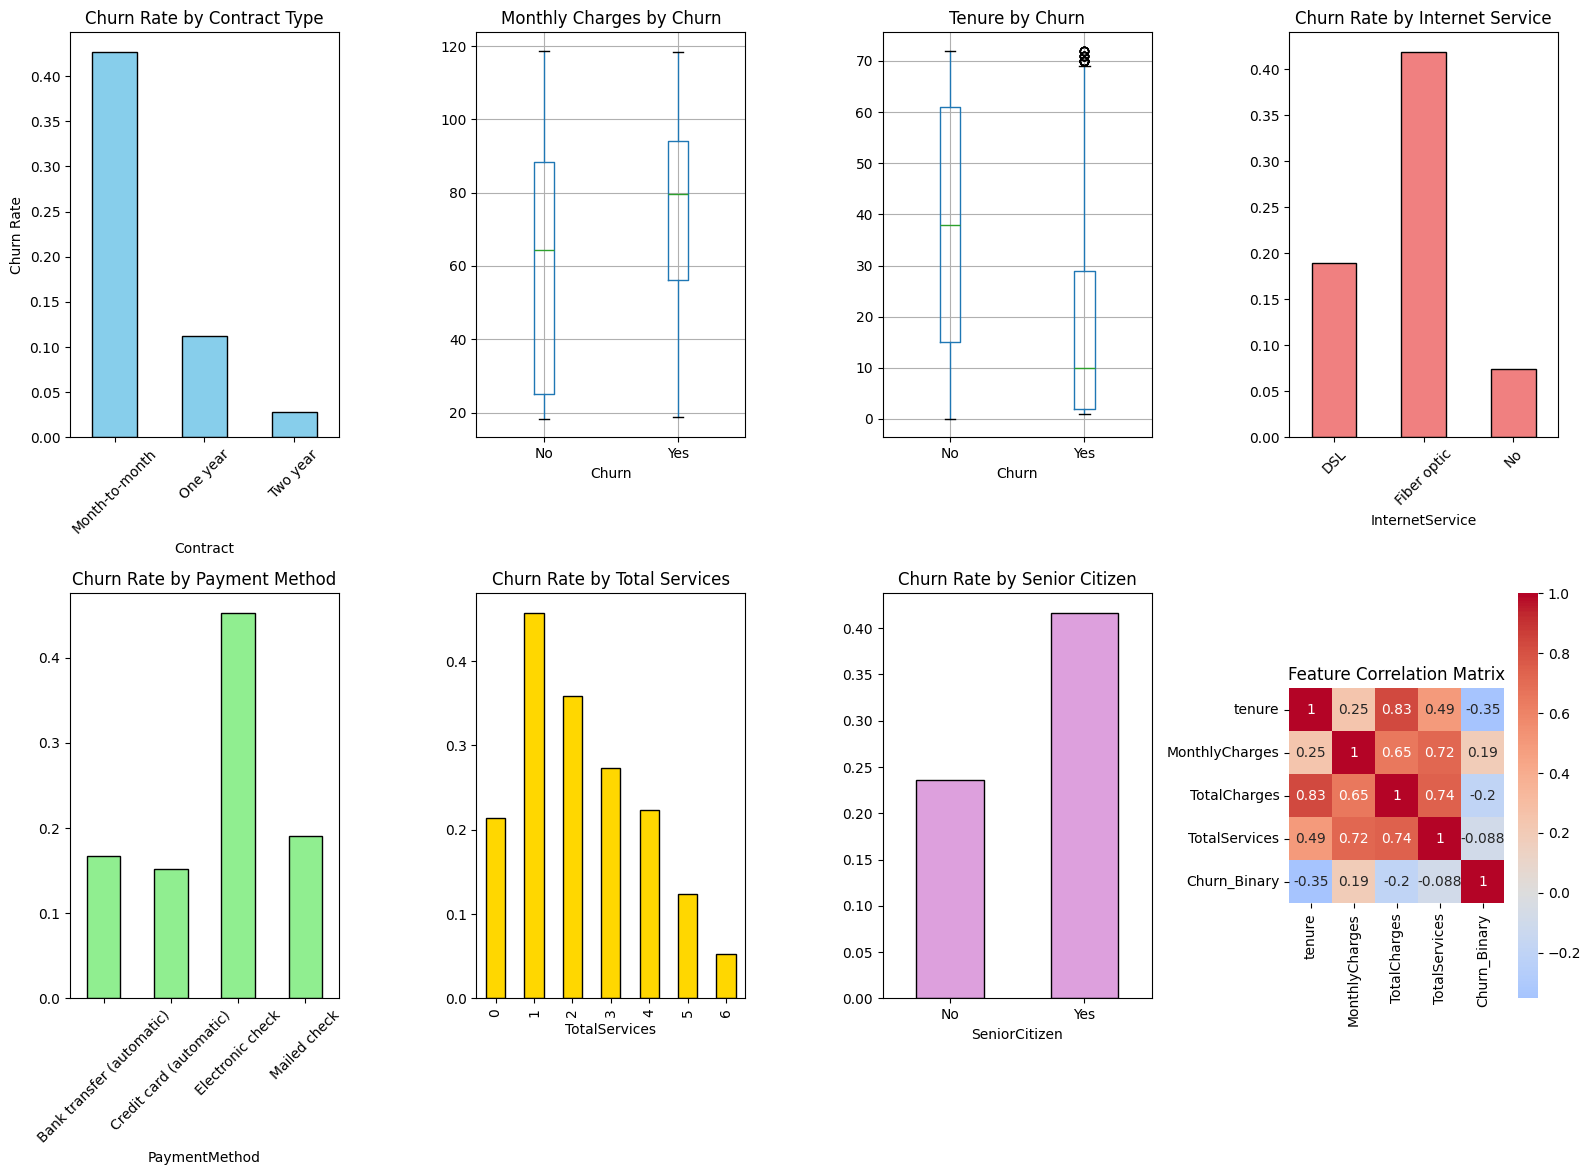


=== KEY INSIGHTS ===
1. Overall churn rate: 26.54%
2. Month-to-month contract churn rate: 42.71%
3. Fiber optic customers churn rate: 41.89%
4. Electronic check payment churn rate: 45.29%


In [13]:
# Create visualizations
plt.figure(figsize=(16, 12))

# 1. Churn rate by contract type
plt.subplot(2, 4, 1)
churn_contract = df_cleaned.groupby('Contract')['Churn_Binary'].mean()
churn_contract.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)

# 2. Monthly charges distribution by churn
plt.subplot(2, 4, 2)
df_cleaned.boxplot(column='MonthlyCharges', by='Churn', ax=plt.gca())
plt.title('Monthly Charges by Churn')
plt.suptitle('')

# 3. Tenure distribution by churn
plt.subplot(2, 4, 3)
df_cleaned.boxplot(column='tenure', by='Churn', ax=plt.gca())
plt.title('Tenure by Churn')
plt.suptitle('')

# 4. Internet service vs churn
plt.subplot(2, 4, 4)
churn_internet = df_cleaned.groupby('InternetService')['Churn_Binary'].mean()
churn_internet.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Churn Rate by Internet Service')
plt.xticks(rotation=45)

# 5. Payment method vs churn
plt.subplot(2, 4, 5)
churn_payment = df_cleaned.groupby('PaymentMethod')['Churn_Binary'].mean()
churn_payment.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Churn Rate by Payment Method')
plt.xticks(rotation=45)

# 6. Total services vs churn
plt.subplot(2, 4, 6)
churn_services = df_cleaned.groupby('TotalServices')['Churn_Binary'].mean()
churn_services.plot(kind='bar', color='gold', edgecolor='black')
plt.title('Churn Rate by Total Services')

# 7. Senior citizen vs churn
plt.subplot(2, 4, 7)
churn_senior = df_cleaned.groupby('SeniorCitizen')['Churn_Binary'].mean()
churn_senior.plot(kind='bar', color='plum', edgecolor='black')
plt.title('Churn Rate by Senior Citizen')
plt.xticks(rotation=0)

# 8. Correlation heatmap of key features
plt.subplot(2, 4, 8)
corr_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices', 'Churn_Binary']
corr_matrix = df_cleaned[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

# Print key insights
print("\n=== KEY INSIGHTS ===")
print(f"1. Overall churn rate: {df_cleaned['Churn_Binary'].mean():.2%}")
print(f"2. Month-to-month contract churn rate: {df_cleaned[df_cleaned['Contract']=='Month-to-month']['Churn_Binary'].mean():.2%}")
print(f"3. Fiber optic customers churn rate: {df_cleaned[df_cleaned['InternetService']=='Fiber optic']['Churn_Binary'].mean():.2%}")
print(f"4. Electronic check payment churn rate: {df_cleaned[df_cleaned['PaymentMethod']=='Electronic check']['Churn_Binary'].mean():.2%}")


# LOGISTIC REGRESSION

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# Assuming you have X_scaled and y from the previous cleaning step
print("=== LOGISTIC REGRESSION MODEL ===")

def train_logistic_regression(X, y, test_size=0.2, random_state=42):
    """
    Train and evaluate logistic regression model
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Training set churn rate: {y_train.mean():.2%}")
    print(f"Test set churn rate: {y_test.mean():.2%}")

    # Initialize and train the model
    lr_model = LogisticRegression(
        random_state=random_state,
        max_iter=1000,  # Increase iterations for convergence
        solver='liblinear'  # Good for smaller datasets
    )

    print("\nTraining Logistic Regression model...")
    lr_model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = lr_model.predict(X_train)
    y_test_pred = lr_model.predict(X_test)

    # Get prediction probabilities
    y_train_prob = lr_model.predict_proba(X_train)[:, 1]
    y_test_prob = lr_model.predict_proba(X_test)[:, 1]

    return lr_model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, y_train_prob, y_test_prob

# Train the model
lr_model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, y_train_prob, y_test_prob = train_logistic_regression(X_scaled, y)

=== LOGISTIC REGRESSION MODEL ===
Training set size: 5634 samples
Test set size: 1409 samples
Training set churn rate: 26.54%
Test set churn rate: 26.54%

Training Logistic Regression model...


In [16]:
def evaluate_model(y_true, y_pred, y_prob, dataset_name=""):
    """
    Comprehensive model evaluation
    """
    print(f"\n=== {dataset_name} SET PERFORMANCE ===")

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)

    print(f"Accuracy:  {accuracy:.4f} ({accuracy:.2%})")
    print(f"Precision: {precision:.4f} ({precision:.2%})")
    print(f"Recall:    {recall:.4f} ({recall:.2%})")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"True Negatives (Stayed):  {cm[0,0]}")
    print(f"False Positives (False Churn): {cm[0,1]}")
    print(f"False Negatives (Missed Churn): {cm[1,0]}")
    print(f"True Positives (Correct Churn): {cm[1,1]}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

# Evaluate on both training and test sets
train_metrics = evaluate_model(y_train, y_train_pred, y_train_prob, "TRAINING")
test_metrics = evaluate_model(y_test, y_test_pred, y_test_prob, "TEST")

# Check for overfitting
print(f"\n=== OVERFITTING CHECK ===")
print(f"Training Accuracy: {train_metrics['accuracy']:.4f}")
print(f"Test Accuracy:     {test_metrics['accuracy']:.4f}")
print(f"Difference:        {train_metrics['accuracy'] - test_metrics['accuracy']:.4f}")

if train_metrics['accuracy'] - test_metrics['accuracy'] > 0.05:
    print("⚠️  Potential overfitting detected!")
else:
    print("✅ Model generalizes well!")


=== TRAINING SET PERFORMANCE ===
Accuracy:  0.8097 (80.97%)
Precision: 0.6779 (67.79%)
Recall:    0.5391 (53.91%)
F1-Score:  0.6006
ROC-AUC:   0.8522

Confusion Matrix:
True Negatives (Stayed):  3756
False Positives (False Churn): 383
False Negatives (Missed Churn): 689
True Positives (Correct Churn): 806

=== TEST SET PERFORMANCE ===
Accuracy:  0.8070 (80.70%)
Precision: 0.6723 (67.23%)
Recall:    0.5321 (53.21%)
F1-Score:  0.5940
ROC-AUC:   0.8472

Confusion Matrix:
True Negatives (Stayed):  938
False Positives (False Churn): 97
False Negatives (Missed Churn): 175
True Positives (Correct Churn): 199

=== OVERFITTING CHECK ===
Training Accuracy: 0.8097
Test Accuracy:     0.8070
Difference:        0.0028
✅ Model generalizes well!


In [17]:
def prepare_predictions_for_database(model, X, y, customer_ids):
    """
    Prepare predictions in format ready for MSSQL storage
    """
    # Get predictions and probabilities
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1]  # Probability of churn

    # Create results dataframe
    results_df = pd.DataFrame({
        'CustomerID': customer_ids,
        'LR_Prediction': predictions,
        'LR_Probability': probabilities,
        'Actual_Churn': y
    })

    # Add risk categories
    results_df['Risk_Category'] = pd.cut(
        results_df['LR_Probability'],
        bins=[0, 0.3, 0.7, 1.0],
        labels=['Low Risk', 'Medium Risk', 'High Risk']
    )

    print("=== PREDICTION SUMMARY ===")
    print(f"Total customers: {len(results_df)}")
    print("\nRisk Distribution:")
    print(results_df['Risk_Category'].value_counts())

    print(f"\nHigh-risk customers (>70% churn probability): {(results_df['LR_Probability'] > 0.7).sum()}")
    print(f"Model accuracy: {accuracy_score(y, predictions):.2%}")

    return results_df

# Prepare predictions (you'll need to get original customer IDs)
# Assuming you have df_cleaned from earlier with customerID column
predictions_df = prepare_predictions_for_database(
    lr_model,
    X_scaled,
    y,
    df_cleaned['customerID']  # Original customer IDs
)

print(predictions_df)
# Save for database insertion
predictions_df.to_csv('logistic_regression_predictions.csv', index=False)
print("\n✅ Predictions saved to 'logistic_regression_predictions.csv'")

=== PREDICTION SUMMARY ===
Total customers: 7043

Risk Distribution:
Risk_Category
Low Risk       4432
Medium Risk    2077
High Risk       534
Name: count, dtype: int64

High-risk customers (>70% churn probability): 534
Model accuracy: 80.92%
      CustomerID  LR_Prediction  LR_Probability  Actual_Churn Risk_Category
0     7590-VHVEG              1        0.647477             0   Medium Risk
1     5575-GNVDE              0        0.038573             0      Low Risk
2     3668-QPYBK              0        0.319894             1   Medium Risk
3     7795-CFOCW              0        0.036021             0      Low Risk
4     9237-HQITU              1        0.745378             1     High Risk
...          ...            ...             ...           ...           ...
7038  6840-RESVB              0        0.109606             0      Low Risk
7039  2234-XADUH              0        0.167001             0      Low Risk
7040  4801-JZAZL              0        0.346630             0   Medium Ri

# XGBOOST

In [18]:
!pip install xgboost

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def train_xgboost_model(X, y, test_size=0.2, random_state=42):
    """
    Train and evaluate XGBoost model for customer churn prediction
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print(f"=== XGBOOST MODEL TRAINING ===")
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Feature count: {X_train.shape[1]}")

    # Initialize XGBoost with optimized parameters for churn prediction
    xgb_model_fixed = XGBClassifier(
      objective='binary:logistic',
      eval_metric='logloss',
      use_label_encoder=False,

      # REDUCED COMPLEXITY PARAMETERS
      n_estimators=100,      # Reduced from 200
      max_depth=4,           # Reduced from 6
      learning_rate=0.1,     # Keep same

      # STRONGER REGULARIZATION
      reg_alpha=10,          # Increased L1 regularization
      reg_lambda=10,         # Increased L2 regularization

      # MORE AGGRESSIVE SAMPLING
      subsample=0.7,         # Reduced from 0.8
      colsample_bytree=0.7,  # Reduced from 0.8

      # EARLY STOPPING
      early_stopping_rounds=10,

      random_state=42,
      n_jobs=-1
  )

    print("Training XGBoost model...")
    # Train with early stopping to prevent overfitting
    xgb_model_fixed.fit(
      X_train, y_train,
      eval_set=[(X_test, y_test)],
      verbose=False
    )

    # Make predictions
    y_train_pred = xgb_model_fixed.predict(X_train)
    y_test_pred = xgb_model_fixed.predict(X_test)

    # Get prediction probabilities
    y_train_prob = xgb_model_fixed.predict_proba(X_train)[:, 1]
    y_test_prob = xgb_model_fixed.predict_proba(X_test)[:, 1]

    return xgb_model_fixed, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, y_train_prob, y_test_prob

# Train the model (assuming X_scaled and y are available from your data cleaning)
xgb_model_fixed, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, y_train_prob, y_test_prob = train_xgboost_model(X_scaled, y)

=== XGBOOST MODEL TRAINING ===
Training set size: 5634 samples
Test set size: 1409 samples
Feature count: 29
Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [18:09:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


In [20]:
def evaluate_xgboost_model(y_true, y_pred, y_prob, dataset_name=""):
    """
    Comprehensive evaluation of XGBoost model performance
    """
    print(f"\n=== {dataset_name} SET PERFORMANCE ===")

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)

    print(f"Accuracy:  {accuracy:.4f} ({accuracy:.2%})")
    print(f"Precision: {precision:.4f} ({precision:.2%})")
    print(f"Recall:    {recall:.4f} ({recall:.2%})")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"True Negatives (Correctly predicted stays):  {cm[0,0]}")
    print(f"False Positives (False churn alerts):        {cm[0,1]}")
    print(f"False Negatives (Missed churns):             {cm[1,0]}")
    print(f"True Positives (Correctly predicted churn):  {cm[1,1]}")

    # Business metrics
    total_churns = cm[1,0] + cm[1,1]
    total_stays = cm[0,0] + cm[0,1]

    print(f"\n=== BUSINESS IMPACT METRICS ===")
    print(f"Total actual churns: {total_churns}")
    print(f"Churns correctly identified: {cm[1,1]} ({cm[1,1]/total_churns:.2%})")
    print(f"Churns missed: {cm[1,0]} ({cm[1,0]/total_churns:.2%})")
    print(f"False alerts: {cm[0,1]} (wasted retention effort)")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

# Evaluate on both sets
train_metrics = evaluate_xgboost_model(y_train, y_train_pred, y_train_prob, "TRAINING")
test_metrics = evaluate_xgboost_model(y_test, y_test_pred, y_test_prob, "TEST")

print(f"\n=== OVERFITTING CHECK ===")
print(f"Training Accuracy: {train_metrics['accuracy']:.4f}")
print(f"Test Accuracy:     {test_metrics['accuracy']:.4f}")
print(f"Difference:        {train_metrics['accuracy'] - test_metrics['accuracy']:.4f}")

if train_metrics['accuracy'] - test_metrics['accuracy'] > 0.05:
    print("⚠️  Potential overfitting detected!")
else:
    print("✅ Model generalizes well!")


=== TRAINING SET PERFORMANCE ===
Accuracy:  0.8204 (82.04%)
Precision: 0.6981 (69.81%)
Recall:    0.5692 (56.92%)
F1-Score:  0.6271
ROC-AUC:   0.8681

Confusion Matrix:
True Negatives (Correctly predicted stays):  3771
False Positives (False churn alerts):        368
False Negatives (Missed churns):             644
True Positives (Correctly predicted churn):  851

=== BUSINESS IMPACT METRICS ===
Total actual churns: 1495
Churns correctly identified: 851 (56.92%)
Churns missed: 644 (43.08%)
False alerts: 368 (wasted retention effort)

=== TEST SET PERFORMANCE ===
Accuracy:  0.8034 (80.34%)
Precision: 0.6633 (66.33%)
Recall:    0.5267 (52.67%)
F1-Score:  0.5872
ROC-AUC:   0.8472

Confusion Matrix:
True Negatives (Correctly predicted stays):  935
False Positives (False churn alerts):        100
False Negatives (Missed churns):             177
True Positives (Correctly predicted churn):  197

=== BUSINESS IMPACT METRICS ===
Total actual churns: 374
Churns correctly identified: 197 (52.67%

In [21]:
def prepare_xgboost_predictions_for_database(model, X, y, customer_ids):
    """
    Prepare XGBoost predictions for database storage alongside LR predictions
    """
    # Get predictions and probabilities
    xgb_predictions = model.predict(X)
    xgb_probabilities = model.predict_proba(X)[:, 1]

    # Create XGBoost results dataframe
    xgb_results_df = pd.DataFrame({
        'CustomerID': customer_ids,
        'XGB_Prediction': xgb_predictions,
        'XGB_Probability': xgb_probabilities,
        'Actual_Churn': y
    })

    # Add risk categories for XGBoost
    xgb_results_df['XGB_Risk_Category'] = pd.cut(
        xgb_results_df['XGB_Probability'],
        bins=[0, 0.3, 0.7, 1.0],
        labels=['Low Risk', 'Medium Risk', 'High Risk']
    )

    print("=== XGBOOST PREDICTION SUMMARY ===")
    print(f"Total customers: {len(xgb_results_df)}")
    print("\nXGBoost Risk Distribution:")
    print(xgb_results_df['XGB_Risk_Category'].value_counts())

    high_risk_xgb = (xgb_results_df['XGB_Probability'] > 0.7).sum()
    print(f"\nHigh-risk customers (>70% churn probability): {high_risk_xgb}")
    print(f"XGBoost model accuracy: {accuracy_score(y, xgb_predictions):.2%}")

    return xgb_results_df

# Generate XGBoost predictions
xgb_predictions_df = prepare_xgboost_predictions_for_database(
    xgb_model_fixed,
    X_scaled,
    y,
    df_cleaned['customerID']  # Make sure this matches your data
)

# Combine with Logistic Regression predictions
combined_predictions = pd.merge(
    predictions_df,  # Your LR predictions
    xgb_predictions_df[['CustomerID', 'XGB_Prediction', 'XGB_Probability', 'XGB_Risk_Category']],
    on='CustomerID'
)

# Save combined predictions for database storage
combined_predictions.to_csv('combined_model_predictions.csv', index=False)
print("\n✅ Combined predictions saved to 'combined_model_predictions.csv'")


=== XGBOOST PREDICTION SUMMARY ===
Total customers: 7043

XGBoost Risk Distribution:
XGB_Risk_Category
Low Risk       4453
Medium Risk    1978
High Risk       612
Name: count, dtype: int64

High-risk customers (>70% churn probability): 612
XGBoost model accuracy: 81.70%

✅ Combined predictions saved to 'combined_model_predictions.csv'
